In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Initiate by importing libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load downloaded Bank Marketing data

df = pd.read_csv("C:/Users/Alf Sanchez/Studies/Post-grad Diploma on AI and ML/Assignments/Capstone/Data/bank-additional-full.csv", sep=';')

# Remove variables relating to social and economic attributes to focus on internal factors
df = df.drop(columns=['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])

# Remove variables relating to time of contact
df = df.drop(columns=['month','day_of_week'])

# Replace 999 with NaN for pdays variable
df['pdays'] = df['pdays'].replace(999, np.nan)

# Convert the predictor variable Y to a binary 0-1 variable
df['y'] = df['y'].map({'no': 0, 'yes': 1})

df.head()

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,261,1,NaN,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,149,1,NaN,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,226,1,NaN,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,151,1,NaN,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,307,1,NaN,0,nonexistent,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        41188 non-null  int64  
 1   job        41188 non-null  object 
 2   marital    41188 non-null  object 
 3   education  41188 non-null  object 
 4   default    41188 non-null  object 
 5   housing    41188 non-null  object 
 6   loan       41188 non-null  object 
 7   contact    41188 non-null  object 
 8   duration   41188 non-null  int64  
 9   campaign   41188 non-null  int64  
 10  pdays      1515 non-null   float64
 11  previous   41188 non-null  int64  
 12  poutcome   41188 non-null  object 
 13  y          41188 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 4.4+ MB


In [10]:
df['y'].value_counts(normalize=True)

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64

Basic Statistics for Age:
count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64



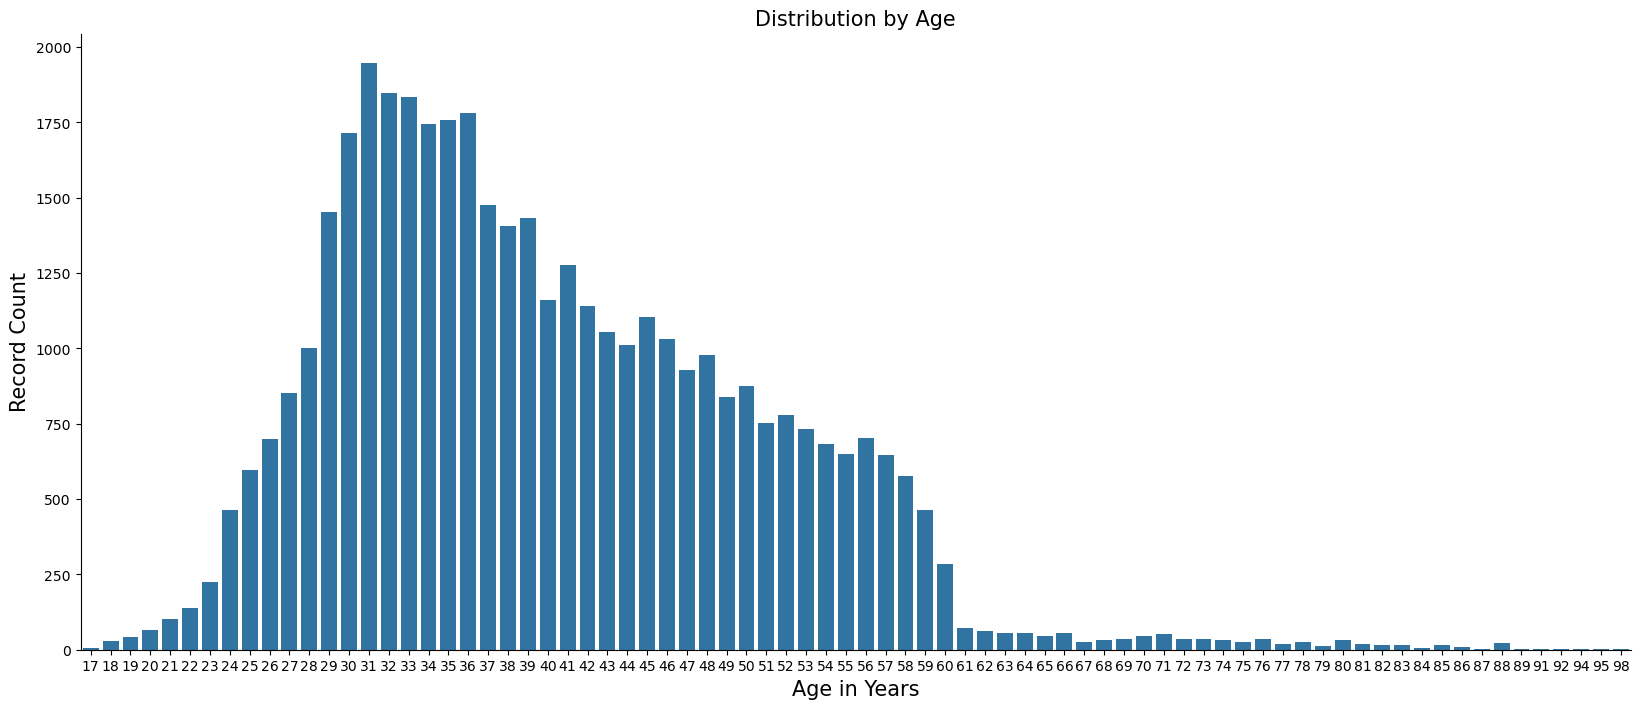

In [12]:
# Exploratory Data Analysis

# For Age
print("Basic Statistics for Age:")
print(df['age'].describe())
print("")

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'age', data = df)
ax.set_xlabel('Age in Years', fontsize=15)
ax.set_ylabel('Record Count', fontsize=15)
ax.set_title('Distribution by Age', fontsize=15)
sns.despine()

Basic Statistics for Campaign Contacts:
count    41188.000000
mean         2.567593
std          2.770014
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         56.000000
Name: campaign, dtype: float64



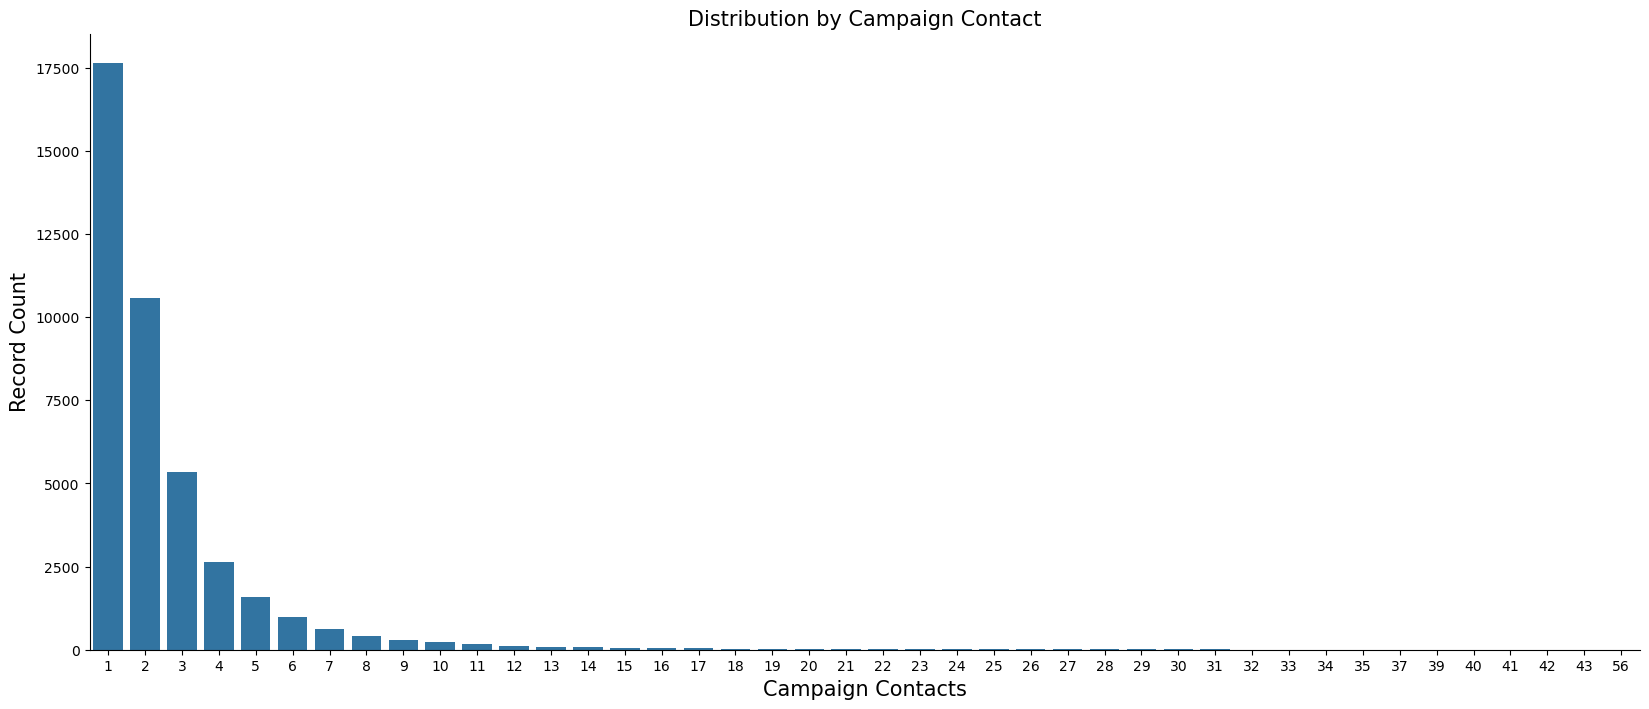

In [14]:
# Exploratory Data Analysis

# For Campaign
print("Basic Statistics for Campaign Contacts:")
print(df['campaign'].describe())
print("")

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'campaign', data = df)
ax.set_xlabel('Campaign Contacts', fontsize=15)
ax.set_ylabel('Record Count', fontsize=15)
ax.set_title('Distribution by Campaign Contact', fontsize=15)
sns.despine()

Basic Statistics for Campaign Contacts:
count    41188.000000
mean         2.193090
std          1.366482
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: campaign, dtype: float64



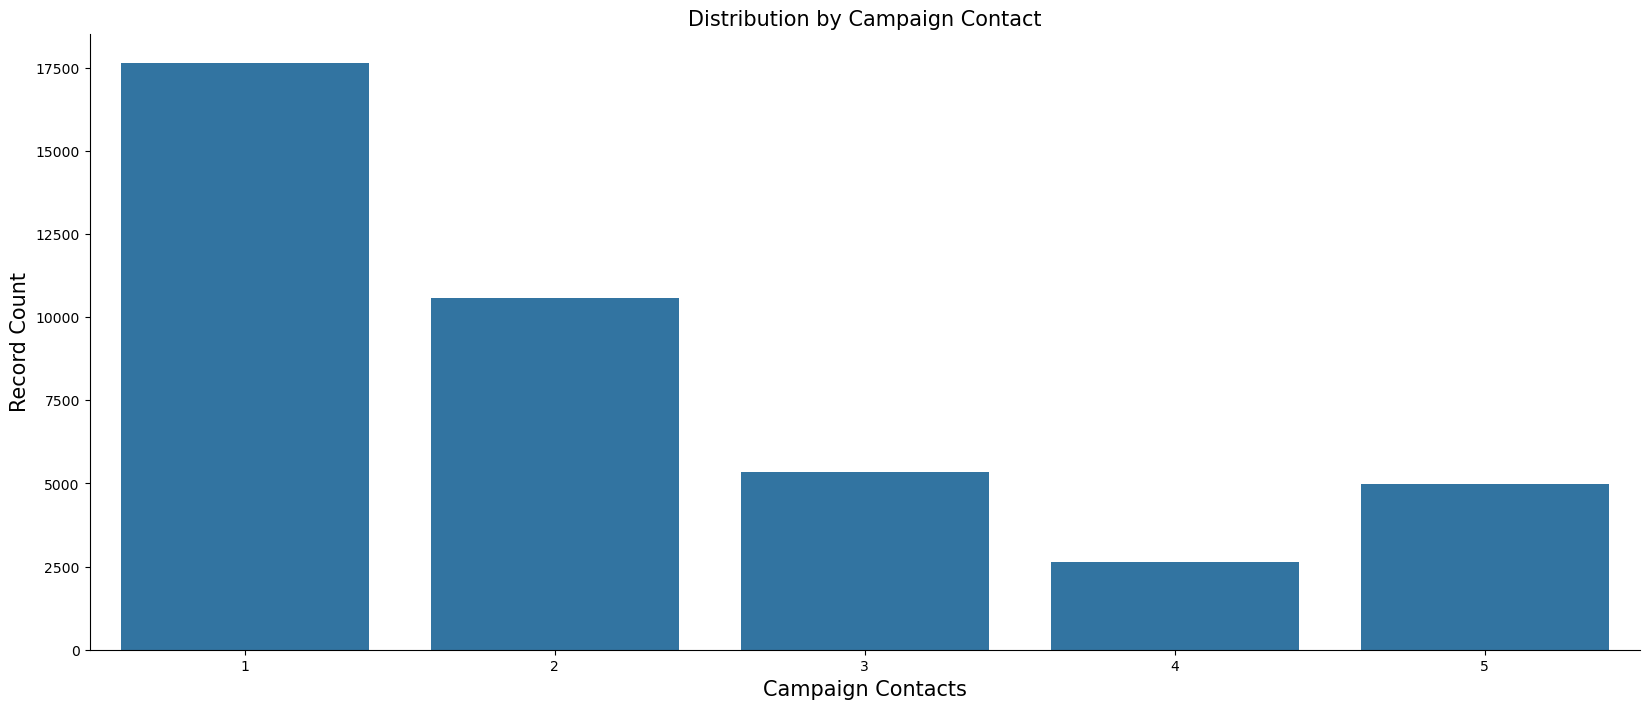

In [16]:
# from the result above, may be best to just cap interactions at 5 and impose a ceiling
df['campaign']=df['campaign'].clip(upper=5)

print("Basic Statistics for Campaign Contacts:")
print(df['campaign'].describe())
print("")

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'campaign', data = df)
ax.set_xlabel('Campaign Contacts', fontsize=15)
ax.set_ylabel('Record Count', fontsize=15)
ax.set_title('Distribution by Campaign Contact', fontsize=15)
sns.despine()

Basic Statistics for Previous Contacts:
count    41188.000000
mean         0.172963
std          0.494901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previous, dtype: float64



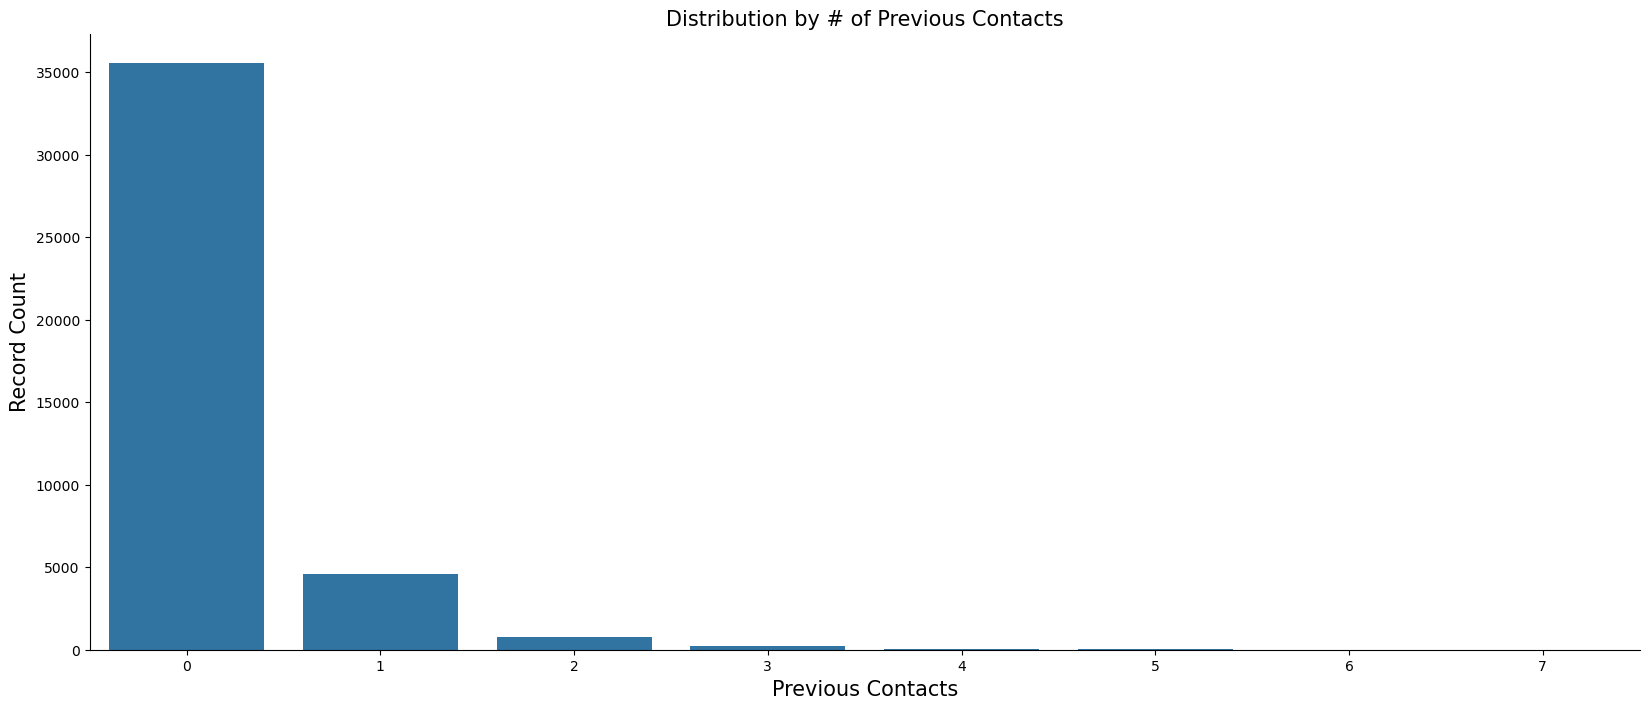

In [18]:
# Exploratory Data Analysis

# For Previous Contacts
print("Basic Statistics for Previous Contacts:")
print(df['previous'].describe())
print("")

fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'previous', data = df)
ax.set_xlabel('Previous Contacts', fontsize=15)
ax.set_ylabel('Record Count', fontsize=15)
ax.set_title('Distribution by # of Previous Contacts', fontsize=15)
sns.despine()


In [20]:
# Create a categorical

# Create categorical variable based on condition
df['prior_contact'] = df['previous'].apply(lambda x: 'no' if x == 0 else 'yes')

# Convert to pandas Categorical type for efficiency
df['prior_contact'] = pd.Categorical(df['prior_contact'], categories=['no', 'yes'])

# Drop the 'previous' variable
df.drop(columns=['previous'], inplace=True)

df['prior_contact'].value_counts(normalize=True)


prior_contact
no     0.863431
yes    0.136569
Name: proportion, dtype: float64

In [22]:
df.head()

,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,poutcome,y,prior_contact
0,56,housemaid,married,basic.4y,no,no,no,telephone,261,1,NaN,nonexistent,0,no
1,57,services,married,high.school,unknown,no,no,telephone,149,1,NaN,nonexistent,0,no
2,37,services,married,high.school,no,yes,no,telephone,226,1,NaN,nonexistent,0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,151,1,NaN,nonexistent,0,no
4,56,services,married,high.school,no,no,yes,telephone,307,1,NaN,nonexistent,0,no


<Axes: xlabel='prior_contact'>

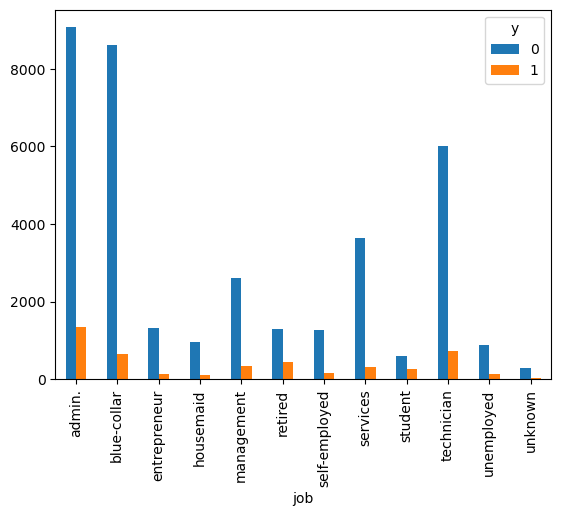

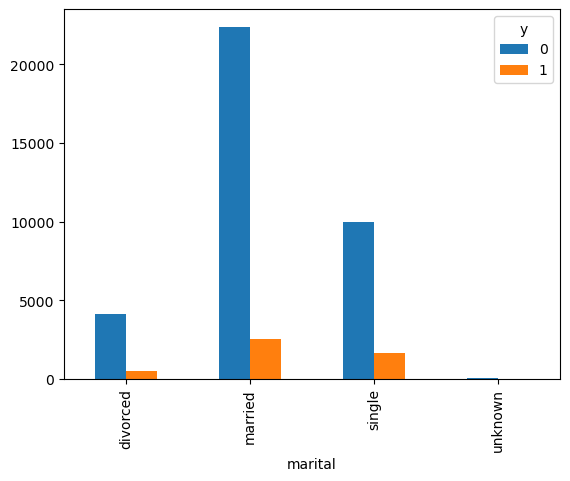

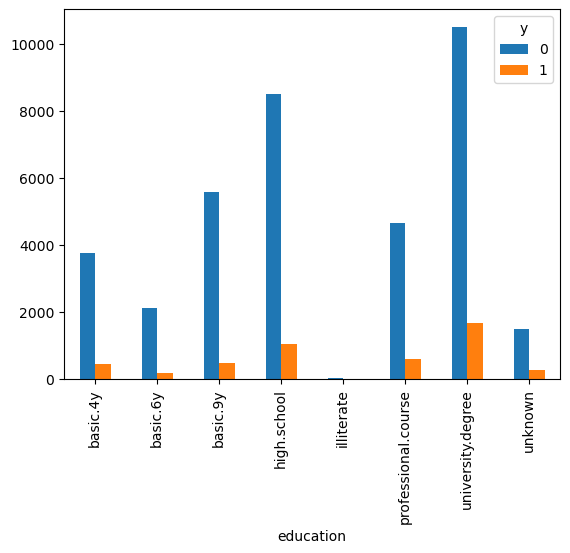

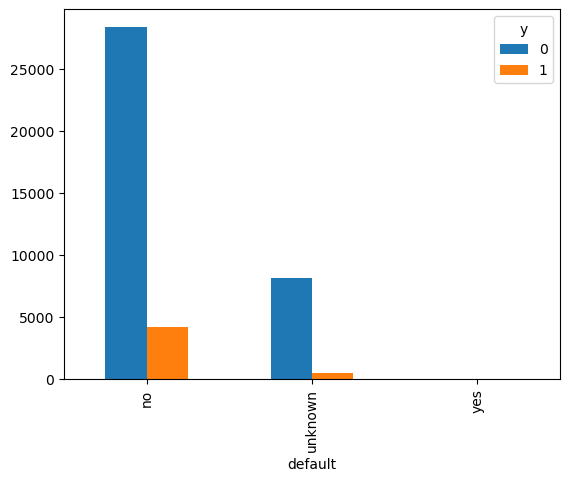

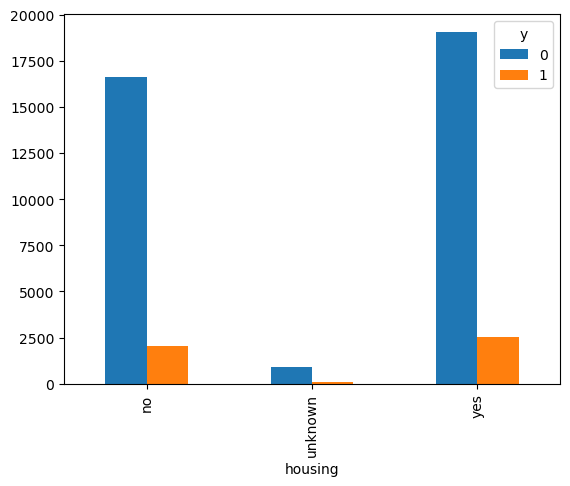

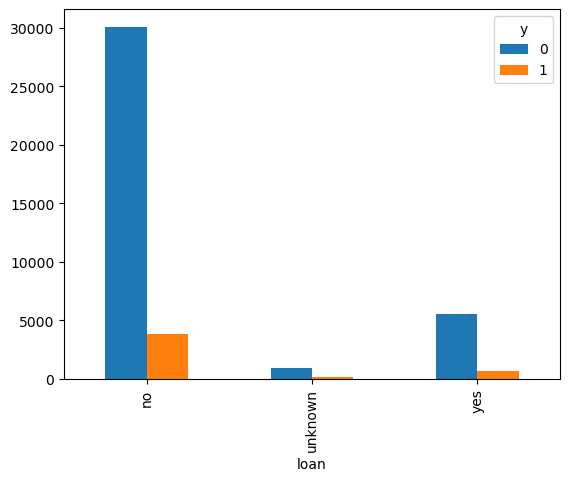

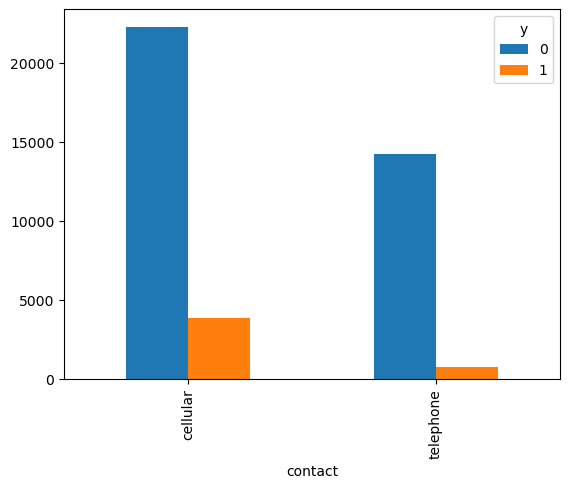

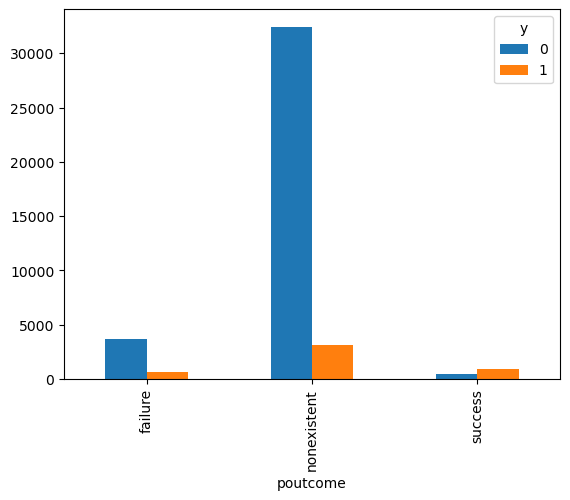

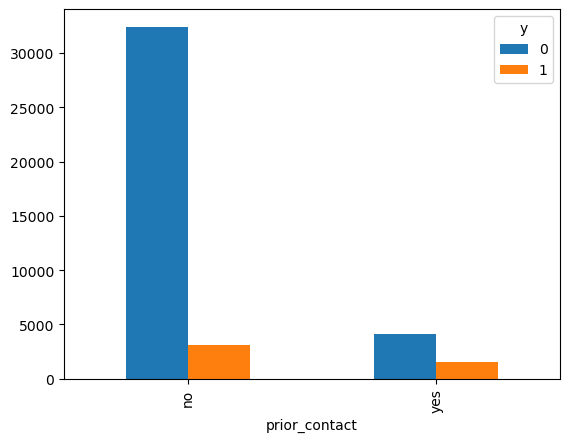

In [24]:
pd.crosstab(df['job'], df['y']).plot(kind='bar')
pd.crosstab(df['marital'], df['y']).plot(kind='bar')
pd.crosstab(df['education'], df['y']).plot(kind='bar')
pd.crosstab(df['default'], df['y']).plot(kind='bar')
pd.crosstab(df['housing'], df['y']).plot(kind='bar')
pd.crosstab(df['loan'], df['y']).plot(kind='bar')
pd.crosstab(df['contact'], df['y']).plot(kind='bar')
pd.crosstab(df['poutcome'], df['y']).plot(kind='bar')
pd.crosstab(df['prior_contact'], df['y']).plot(kind='bar')

In [26]:
# Create a two-way frequency table for two columns
freq_table = pd.crosstab(df['job'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['marital'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['education'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['default'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['housing'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['loan'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['contact'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['poutcome'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

freq_table = pd.crosstab(df['prior_contact'], df['y'], normalize='index') * 100
freq_table = freq_table.round(2)
print(freq_table)
print("")

y                  0      1
job                        
admin.         87.03  12.97
blue-collar    93.11   6.89
entrepreneur   91.48   8.52
housemaid      90.00  10.00
management     88.78  11.22
retired        74.77  25.23
self-employed  89.51  10.49
services       91.86   8.14
student        68.57  31.43
technician     89.17  10.83
unemployed     85.80  14.20
unknown        88.79  11.21

y             0      1
marital               
divorced  89.68  10.32
married   89.84  10.16
single    86.00  14.00
unknown   85.00  15.00

y                        0      1
education                        
basic.4y             89.75  10.25
basic.6y             91.80   8.20
basic.9y             92.18   7.82
high.school          89.16  10.84
illiterate           77.78  22.22
professional.course  88.65  11.35
university.degree    86.28  13.72
unknown              85.50  14.50

y             0      1
default               
no        87.12  12.88
unknown   94.85   5.15
yes      100.00   0.00

y          

In [ ]:
# From the above we can deduce some higher likelihood of availment to create a baseline rule-based challenger

C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^

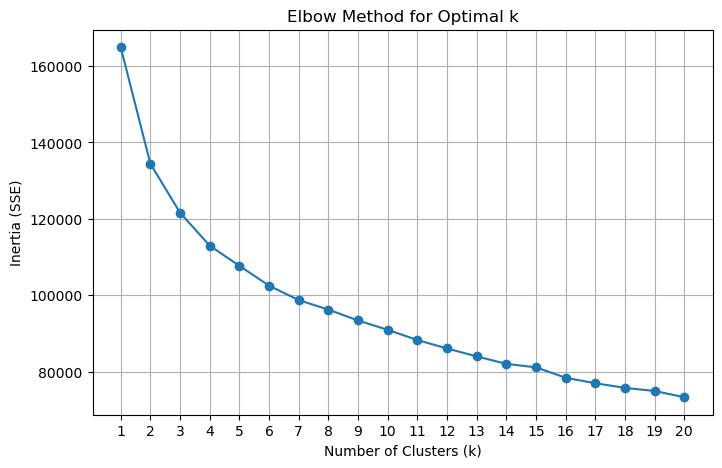

In [28]:
# Create customer segmentation

segmentation_features_num = ['age']
segmentation_features_cat = ['job', 'marital', 'education', 'housing', 'loan']

seg_numeric_transformer = StandardScaler()
seg_categorical_transformer = OneHotEncoder(handle_unknown='ignore')

seg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', seg_numeric_transformer, segmentation_features_num),
        ('cat', seg_categorical_transformer, segmentation_features_cat)
    ]
)

# Prepare the data for clustering by applying the preprocessor
X_clust = seg_preprocessor.fit_transform(df[segmentation_features_num + segmentation_features_cat])

# Determing the number of clusters to use
inertia_values = []
k_values = range(1, 21)  # Test k from 1 to 20 #initial number was to look at up to 10 but expanded it given no clear elbow

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=11, n_init=10)
    kmeans.fit(X_clust) # Fit KMeans on the preprocessed data
    inertia_values.append(kmeans.inertia_)  # Sum of squared distances to nearest cluster center

# -----------------------------
# 3. Plot the Elbow Graph
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [30]:
# Choose K = 6 for customer segmentation

K = 6
kmeans = KMeans(n_clusters=K, random_state=11, n_init=10)

segmentation_pipeline = Pipeline(steps=[
    ('preprocess', seg_preprocessor),
    ('cluster', kmeans)
])

df['segment'] = segmentation_pipeline.fit_predict(df[segmentation_features_num + segmentation_features_cat])
df['segment'].value_counts()

# Interpret segments
df.groupby('segment')[segmentation_features_num + segmentation_features_cat].agg(lambda x: x.value_counts().index[0])

,age,job,marital,education,housing,loan
segment,,,,,,
0,30,admin.,single,university.degree,no,no
1,48,blue-collar,married,university.degree,yes,no
2,46,blue-collar,married,university.degree,no,no
3,36,blue-collar,married,university.degree,yes,no
4,31,admin.,single,university.degree,yes,no
5,36,blue-collar,married,university.degree,no,no


In [34]:
# Develop the Propensity Model

all_features = [
    'age', 'job', 'marital', 'education', 'default','housing', 'loan','contact', 'poutcome'
] 
target = 'y'

features_for_model = all_features.copy()
if 'segment' not in features_for_model:
    features_for_model.append('segment')

X = df[features_for_model]
y = df[target]

In [36]:
# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=11, stratify=y
)

# Define numerical and categorical features for the propensity model
numerical_features = ['age']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'segment']

# Preprocessing steps
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Handle NaNs in pdays
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor for the entire dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any, though 'features_for_model' should cover all)
)

# Apply preprocessing to training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=11),
    "Gradient Boosting": GradientBoostingClassifier(random_state=11),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, # Deprecated in newer versions, but keep for compatibility
        eval_metric="logloss",
        random_state=11
    )
}

# Train and evaluate models
results = []

for name, model in models.items():
    # All models will now use the preprocessed data
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    y_prob = model.predict_proba(X_test_processed)[:, 1]

    # Calculate metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

# Display results for comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:\n")
print(results_df.sort_values(by="ROC-AUC", ascending=False).to_string(index=False))

C:\Anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:55:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Model Performance Comparison:

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  Gradient Boosting  0.896010   0.630170 0.186063  0.287299 0.734525
Logistic Regression  0.896981   0.651399 0.183908  0.286835 0.722916
            XGBoost  0.894068   0.596288 0.184626  0.281953 0.714449


Best parameters found (Grid Search): {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score (Grid Search): 0.6784707217094692
Best parameters found (Random Search): {'C': 1.7477481403880757, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV score (Random Search): 0.6785054078003466


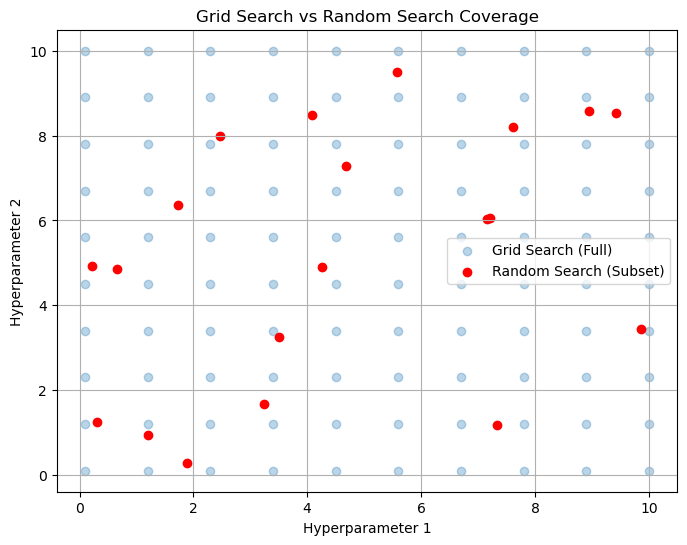

In [38]:
# Choose Logistic Regression due to explainability


## Gridsearch

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=11), param_grid, cv=5)
grid.fit(X_train_processed, y_train)

print("Best parameters found (Grid Search):", grid.best_params_)
print("Best CV score (Grid Search):", grid.best_score_)

## Random Search

param_dist = {
    'C': uniform(0.01, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
random_search = RandomizedSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced', random_state=11), param_distributions=param_dist, n_iter=100, cv=5, random_state=11)
random_search.fit(X_train_processed, y_train)

print("Best parameters found (Random Search):", random_search.best_params_)
print("Best CV score (Random Search):", random_search.best_score_)


# Comparison and Simulated grid
# Note: The plot below is conceptual and doesn't use actual hyperparameter values
# It illustrates the search space coverage of Grid Search vs. Random Search
param1 = np.linspace(0.1, 10, 10)
param2 = np.linspace(0.1, 10, 10)
grid_points = [(x, y) for x in param1 for y in param2]
np.random.seed(11) # Set the seed for reproducibility
random_points = [tuple(np.random.uniform(0.1, 10, 2)) for _ in range(20)]

plt.figure(figsize=(8, 6))
plt.scatter(*zip(*grid_points), label='Grid Search (Full)', alpha=0.3)
plt.scatter(*zip(*random_points), label='Random Search (Subset)', c='red')
plt.xlabel('Hyperparameter 1')
plt.ylabel('Hyperparameter 2')
plt.title("Grid Search vs Random Search Coverage")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Build logistic regression models

#model (original)
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (Original):", acc)
report = classification_report(y_test, y_pred)
print("\nClassification Report (Original):\n", report)

#model from Grid Search
model = LogisticRegression(C=10, penalty='l1', solver='liblinear', class_weight='balanced')
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (Grid Search):", acc)
report = classification_report(y_test, y_pred)
print("\nClassification Report (Grid Search):\n", report)

#model from Random Search
model = LogisticRegression(C=1.7477, penalty='l1', solver='liblinear', class_weight='balanced')
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score (Random Search):", acc)
report = classification_report(y_test, y_pred)
print("\nClassification Report (Random Search):\n", report)

Accuracy Score (Original): 0.683094602249737

Classification Report (Original):
               precision    recall  f1-score   support

           0       0.94      0.69      0.79     10965
           1       0.21      0.63      0.31      1392

    accuracy                           0.68     12357
   macro avg       0.57      0.66      0.55     12357
weighted avg       0.85      0.68      0.74     12357

Accuracy Score (Grid Search): 0.6823662701302905

Classification Report (Grid Search):
               precision    recall  f1-score   support

           0       0.94      0.69      0.79     10965
           1       0.20      0.63      0.31      1392

    accuracy                           0.68     12357
   macro avg       0.57      0.66      0.55     12357
weighted avg       0.85      0.68      0.74     12357

Accuracy Score (Random Search): 0.6824471959213402

Classification Report (Random Search):
               precision    recall  f1-score   support

           0       0.94      0

In [42]:
#Final model (original one)
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.94      0.69      0.79     10965
           1       0.21      0.63      0.31      1392

    accuracy                           0.68     12357
   macro avg       0.57      0.66      0.55     12357
weighted avg       0.85      0.68      0.74     12357

ROC AUC: 0.7229130632472182


In [44]:
# Show variables (features) included
print("Variables included in the model:")
print(list(X.columns))

# Get feature names after preprocessing
feature_names_processed = preprocessor.get_feature_names_out()

# Show coefficients for each variable
coef_df = pd.DataFrame({
    'Variable': feature_names_processed,
    'Coefficient': model.coef_[0]
})
print("\nCoefficients:")
print(coef_df)

Variables included in the model:
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'segment']

Coefficients:
                              Variable  Coefficient
0                             num__age     0.077056
1                      cat__job_admin.    -0.082669
2                 cat__job_blue-collar    -0.351508
3                cat__job_entrepreneur    -0.362911
4                   cat__job_housemaid    -0.178744
5                  cat__job_management    -0.306006
6                     cat__job_retired     0.640901
7               cat__job_self-employed    -0.130603
8                    cat__job_services    -0.269317
9                     cat__job_student     0.880447
10                 cat__job_technician    -0.184684
11                 cat__job_unemployed     0.154064
12                    cat__job_unknown     0.252665
13               cat__marital_divorced     0.063944
14                cat__marital_married     0.154310
15               

In [46]:
# STRATEGY SIMULATION
# assumed contact rate is 30%

test = X_test.copy()
test['y_true'] = y_test
test['proba'] = y_proba

n_test = len(test)
contact_rate = 0.3
n_to_contact = int(contact_rate * n_test)
n_to_contact

3707

In [50]:
# RANDOM

def evaluate_strategy(contact_mask, df_test):
    contacted = df_test[contact_mask]
    if len(contacted) == 0:
        return {
            'contacts': 0,
            'accepts': 0,
            'accept_rate': 0.0
        }
    accepts = contacted['y_true'].sum()
    return {
        'contacts': len(contacted),
        'accepts': int(accepts),
        'accept_rate': accepts / len(contacted)
    }

seed = 11 # use seed for reproducibility
np.random.seed(seed)

# Random
random_mask = pd.Series(False, index=test.index)
random_indices = np.random.choice(test.index, size=n_to_contact, replace=False)
random_mask.loc[random_indices] = True

res_random = evaluate_strategy(random_mask, test)
res_random

{'contacts': 3707, 'accepts': 409, 'accept_rate': 0.11033180469382249}

In [52]:
# RULE BASED

rule_mask = (
    ((test['age'].between(30, 60)) &
    (test['contact'] == 'cellular')) |
    (test['poutcome'] == 'success')
)

seed = 11 # use seed for reproducibility
np.random.seed(seed)

# Downsample randoly if more than planned 
rule_indices = test[rule_mask].index
if len(rule_indices) > n_to_contact:
    rule_indices = np.random.choice(rule_indices, size=n_to_contact, replace=False)

rule_mask_final = pd.Series(False, index=test.index)
rule_mask_final.loc[rule_indices] = True

res_rule = evaluate_strategy(rule_mask_final, test)
res_rule

{'contacts': 3707, 'accepts': 500, 'accept_rate': 0.1348799568384138}

In [54]:
# Logistic Regression Model

test_sorted = test.sort_values('proba', ascending=False)
ml_indices = test_sorted.head(n_to_contact).index

ml_mask = pd.Series(False, index=test.index)
ml_mask.loc[ml_indices] = True

res_ml = evaluate_strategy(ml_mask, test)
res_ml



{'contacts': 3707, 'accepts': 813, 'accept_rate': 0.21931480981926085}

              strategy  contacts  accepts  accept_rate
0               Random      3707      409     0.110332
1           Rule-based      3707      500     0.134880
2  Logistic Regression      3707      813     0.219315


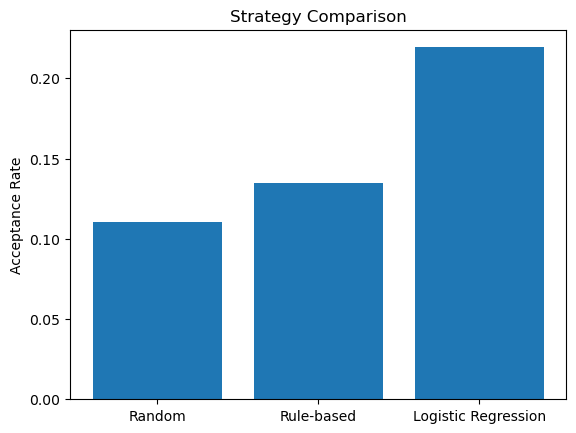

In [56]:
# COMPARISON

results = pd.DataFrame([
    {'strategy': 'Random', **res_random},
    {'strategy': 'Rule-based', **res_rule},
    {'strategy': 'Logistic Regression', **res_ml}
])

print(results)

plt.bar(results['strategy'], results['accept_rate'])
plt.ylabel("Acceptance Rate")
plt.title("Strategy Comparison")
plt.show()

In [58]:
pip install flask

Note: you may need to restart the kernel to use updated packages.


In [60]:
# Save model for deployment

import joblib
joblib.dump(model, "AS_capstone_bank_marketing.pkl")


['AS_capstone_bank_marketing.pkl']

In [ ]:
# app.py
from flask import Flask, render_template, request, jsonify
import joblib
import numpy as np

app = Flask(__name__)

# Load the trained model
try:
    model = joblib.load("AS_capstone_bank_marketing.pkl")
except FileNotFoundError:
    raise RuntimeError("Model file not found. Train and save the model first.")

@app.route("/")
def home():
    return {"message": "Prediction ongoing."}

@app.route("/predict", methods=["POST"])
def predict():
    try:
        # Expecting JSON input
        data = request.get_json()
        if not data or "features" not in data:
            return jsonify({"error": "Invalid input. Provide 'features' list."}), 400
        
        features = np.array(data["features"]).reshape(1, -1)
               
        prediction = model.predict(features)
        return jsonify({"prediction": int(prediction[0])})
    
    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == "__main__":
    app.run(debug=True)

In [ ]:
import requests

url = "http://127.0.0.1:5000/predict"
data = {"features": [45, "blue-collar", "single", "university.degree", "no", "yes", "no", "cellular", "success", "4"]} 
response = requests.post(url, json=data)
print(response.json())

In [1]:
# Export as a technical file for presentation
!jupyter nbconvert --to html Capstone_AS.ipynb


This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'Capstone_AS.ipynb' matched no files
